This notebook is part of an article about how to forecast and detect anomalies on time-series data. The main objective is to train a RNN regressor on the Bitcoin dataset to predict future values on then detect anomalies in the whole data window - that last step achieved by implementing a RNN Autoencoder.

You'll see some other models in the notebook that I've provided to you in case they are of your interest and this RNN regressor + RNN Autoencoder doesn't perform well for your purpose in any other scenario.

The dataset used is available at https://www.kaggle.com/mczielinski/bitcoin-historical-data and contains BITCOIN/USD 1-minute candle data, from 2012-01-01 to 2020-12-31. I hope you can get advantage of this approach!

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import gc
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import json
import urllib
from datetime import datetime, timedelta,timezone
import requests

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv


In [2]:
btc = pd.read_csv('/kaggle/input/bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv')
btc.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN

# Data preprocessing
Let's resample the data, take only the variable we're going to use and determine what's the window of data that's more meaningful for our purpose. Let's also clean null values.

In [3]:
btc['Timestamp'] = pd.to_datetime(btc.Timestamp, unit='s')
btc.head()

Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 07:52:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 07:53:00   NaN   NaN   NaN    NaN           NaN   
2 2011-12-31 07:54:00   NaN   NaN   NaN    NaN           NaN   
3 2011-12-31 07:55:00   NaN   NaN   NaN    NaN           NaN   
4 2011-12-31 07:56:00   NaN   NaN   NaN    NaN           NaN   

   Volume_(Currency)  Weighted_Price  
0                2.0            4.39  
1                NaN             NaN  
2                NaN             NaN  
3                NaN             NaN  
4                NaN             NaN

In [4]:
print('Minutes in dataset: ',len(btc))
print('Hours in dataset: ',len(btc)/60)
print('Days in dataset: ',len(btc)/60/24)

Minutes in dataset:  4727777
Hours in dataset:  78796.28333333334
Days in dataset:  3283.1784722222224


In [5]:
btc = btc[['Timestamp','Weighted_Price']]
btc.head()

Timestamp  Weighted_Price
0 2011-12-31 07:52:00            4.39
1 2011-12-31 07:53:00             NaN
2 2011-12-31 07:54:00             NaN
3 2011-12-31 07:55:00             NaN
4 2011-12-31 07:56:00             NaN

In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727777 entries, 0 to 4727776
Data columns (total 2 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Timestamp       datetime64[ns]
 1   Weighted_Price  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 72.1 MB


In [7]:
# Data re-sampling based on 1 hour
# If you want to sample by day, change H by D
btc = btc.resample('H', on='Timestamp')[['Weighted_Price']].mean()

Let's plot the whole panorama to visually understand what portion of the set must me removed

In [8]:
    pano = btc.copy() #We're going to use this later
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pano.index, y=pano['Weighted_Price'],name='Full history BTC price'))
    fig.update_layout(showlegend=True,title="BTC price history",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
    fig.show()

As you can see above, there's a portion of data at the beginning of the set that contains null values. In addition, those are values that are not common in the current BTC price. We need to get rid of them.

In [9]:
print('Starting date selected: ',btc.index[51000])
print('NaN values: ',btc.iloc[51000:].isna().sum())

Starting date selected:  2017-10-25 07:00:00
NaN values:  Weighted_Price    4
dtype: int64


In [10]:
btc = btc.iloc[51000:]
btc.fillna(method ='bfill', inplace = True)
print('NaN values: ',btc.isna().sum())

NaN values:  Weighted_Price    0
dtype: int64


In [11]:
print('New data points quantity: ',len(btc))

New data points quantity:  27906


Let's see how the new dataset looks like once the null and the close-to-cero values were removed.

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=btc.index, y=btc['Weighted_Price'],name='BTC price'))
fig.update_layout(showlegend=True,title="BTC price history",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

Now that charts fits better with the current BTC price reality. Let's use those samples as our new dataset.

# Data Splitting
We're going to take the test set as the first 20% window. The next 80s as the training set.

In [13]:
data_for_us = btc.copy() #To be used later on Unsupervised Learning
training_start = int(len(btc) * 0.2)

train = btc.iloc[training_start:]
test = btc.iloc[:training_start]
print("Total datasets' lenght: ",train.shape, test.shape)

Total datasets' lenght:  (22325, 1) (5581, 1)


# Data scaling

This stage is extremely important as a requisite to train Neural Networks. If you skip this step maybe your model won't converge.

In [14]:
scaler = MinMaxScaler().fit(train[['Weighted_Price']])

In [15]:
def scale_samples(data,column_name,scaler):
    data[column_name] = scaler.transform(data[[column_name]])
    return data

In [16]:
joblib.dump(scaler, 'scaler.gz')
scaler = joblib.load('scaler.gz')

In [17]:
train = scale_samples(train.copy(),train.columns[0],scaler)
train.head()

Weighted_Price
Timestamp                          
2018-06-14 20:00:00        0.136056
2018-06-14 21:00:00        0.136478
2018-06-14 22:00:00        0.135322
2018-06-14 23:00:00        0.135120
2018-06-15 00:00:00        0.135367

In [18]:
test = scale_samples(test,test.columns[0],scaler)
test.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Weighted_Price
Timestamp                          
2017-10-25 07:00:00        0.094117
2017-10-25 08:00:00        0.095784
2017-10-25 09:00:00        0.096150
2017-10-25 10:00:00        0.094869
2017-10-25 11:00:00        0.092179

# Sequences generation and dataset creation

In [19]:
def shift_samples(data,column_name,lookback=24):
    """This function takes a *data* dataframe and returns two numpy arrays: 
    - X corresponds to the same values but packed into n frames of *lookback* values each
    - Y corresponds to the sample shifted *lookback* steps to the future
    """
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback)):
        x_floats = np.array(data.iloc[i:i+lookback])
        y_floats = np.array(data.iloc[i+lookback])
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)

In [20]:
X_train, y_train = shift_samples(train[['Weighted_Price']],train.columns[0])
X_test, y_test = shift_samples(test[['Weighted_Price']], test.columns[0])
gc.collect()

308

In [21]:
print("Final datasets' shapes:")
print('X_train: '+str(X_train.shape)+', y_train: '+str(y_train.shape))
print('X_test: '+str(X_test.shape)+', y_train: '+str(y_test.shape))

Final datasets' shapes:
X_train: (22301, 24, 1), y_train: (22301, 1)
X_test: (5557, 24, 1), y_train: (5557, 1)


In [22]:
tsteps = X_train.shape[1]
nfeatures = X_train.shape[2]

# Anomaly detectors' training
## LSTM Autoencoder Neural Network

The one that we'll be using along this notebook.

In [23]:
#First model - LSTM Autoencoder for anomaly detections

detector = Sequential()
detector.add(layers.LSTM(128, input_shape=(tsteps, nfeatures),dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.RepeatVector(tsteps))
detector.add(layers.LSTM(128, return_sequences=True,dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.TimeDistributed(layers.Dense(nfeatures))) 

detector.compile(loss='mae', optimizer='adam')
detector.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [24]:
checkpoint = ModelCheckpoint("/kaggle/working/detector.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history1 = detector.fit(X_train,y_train,epochs=50,batch_size=128,verbose=1,validation_split=0.1,callbacks=[checkpoint],shuffle=False)

Epoch 1/50
151/157 [===========================>..] - ETA: 0s - loss: 0.0411
Epoch 00001: val_loss improved from inf to 0.19951, saving model to /kaggle/working/detector.hdf5
157/157 [==============================] - 3s 20ms/step - loss: 0.0412 - val_loss: 0.1995
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.0427
Epoch 00002: val_loss improved from 0.19951 to 0.15993, saving model to /kaggle/working/detector.hdf5
157/157 [==============================] - 1s 7ms/step - loss: 0.0427 - val_loss: 0.1599
Epoch 3/50
151/157 [===========================>..] - ETA: 0s - loss: 0.0459
Epoch 00003: val_loss did not improve from 0.15993
157/157 [==============================] - 1s 7ms/step - loss: 0.0457 - val_loss: 0.1623
Epoch 4/50
153/157 [============================>.] - ETA: 0s - loss: 0.0526
Epoch 00004: val_loss improved from 0.15993 to 0.15149, saving model to /kaggle/working/detector.hdf5
157/157 [==============================] - 1s 8ms/step - loss: 0.0523 -

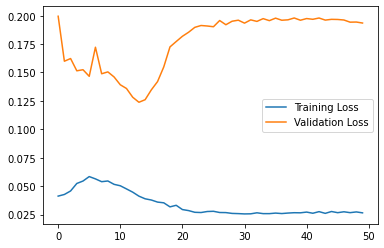

In [25]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()

In [26]:
#Let's load the best model obtained during training
detector = load_model("detector.hdf5")
detector.evaluate(X_test, y_test)

174/174 [==============================] - 1s 3ms/step - loss: 0.0603


0.06030819192528725

### Determining threshold for Autoencoder detector

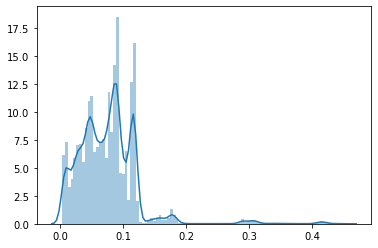

In [27]:
X_train_pred = detector.predict(X_train)
loss_mae = np.mean(np.abs(X_train_pred - X_train), axis=1) #This is the formula to calculate MAE
sns.distplot(loss_mae, bins=100, kde=True)

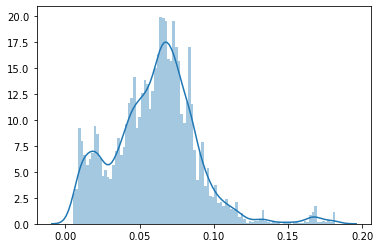

In [28]:
X_test_pred = detector.predict(X_test)
loss_mae = np.mean(np.abs(X_test_pred - X_test), axis=1) 
sns.distplot(loss_mae, bins=100, kde=True)

As you can see in the charts from above, observations after 0.150 become unusual. Let's set that number as the threshold.

In [29]:
threshold = 0.15

test_df = pd.DataFrame(test[tsteps:])
test_df['loss'] = loss_mae
test_df['threshold'] = threshold
test_df['anomaly'] = test_df.loss > test_df.threshold
test_df['Weighted_Price'] = test[tsteps:].Weighted_Price

### Plotting prices' anomalies

In [30]:
anomalies = test_df[test_df.anomaly == True]
anomalies.head()

Weighted_Price      loss  threshold  anomaly
Timestamp                                                        
2017-12-17 04:00:00        0.617943  0.151630       0.15     True
2017-12-17 05:00:00        0.621948  0.154248       0.15     True
2017-12-17 06:00:00        0.626874  0.156642       0.15     True
2017-12-17 07:00:00        0.631961  0.158813       0.15     True
2017-12-17 08:00:00        0.630656  0.160752       0.15     True

In [31]:
yvals1 = scaler.inverse_transform(test[tsteps:][['Weighted_Price']])
yvals1 = yvals1.reshape(-1)

In [32]:
yvals2 = scaler.inverse_transform(anomalies[['Weighted_Price']])
yvals2 = yvals2.reshape(-1)

In [33]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[tsteps:].index, y=yvals1,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=anomalies.index, y=yvals2,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

In [34]:
scaled_pano = test.append(train, ignore_index=False)
X_shifted, y_shifted = shift_samples(scaled_pano[['Weighted_Price']], scaled_pano.columns[0])
print("Scaled pano datasets' shapes:")
print('X_shifted: '+str(X_shifted.shape)+', y_shifted: '+str(y_shifted.shape))

Scaled pano datasets' shapes:
X_shifted: (27882, 24, 1), y_shifted: (27882, 1)


In [35]:
X_shifted_pred = detector.predict(X_shifted)
loss_mae = np.mean(np.abs(X_shifted_pred - X_shifted), axis=1)

In [36]:
non_scaled_pano = pano.copy()[51000:]
non_scaled_pano.fillna(method ='bfill', inplace = True)
non_scaled_pano = non_scaled_pano[:-24]

In [37]:
non_scaled_pano['loss_mae'] = loss_mae
non_scaled_pano['threshold'] = threshold
non_scaled_pano['anomaly'] = non_scaled_pano.loss_mae > non_scaled_pano.threshold
non_scaled_pano.head()

Weighted_Price  loss_mae  threshold  anomaly
Timestamp                                                        
2017-10-25 07:00:00     5566.168248  0.101701       0.15    False
2017-10-25 08:00:00     5609.117907  0.101354       0.15    False
2017-10-25 09:00:00     5618.544111  0.101100       0.15    False
2017-10-25 10:00:00     5585.530009  0.100899       0.15    False
2017-10-25 11:00:00     5516.217082  0.100730       0.15    False

In [38]:
pano_outliers = non_scaled_pano[non_scaled_pano['anomaly'] == True]

In [39]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=non_scaled_pano.index, y=non_scaled_pano['Weighted_Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=pano_outliers.index, y=pano_outliers['Weighted_Price'].values,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies - Autoencoder",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

## Isolation forest model (Bonus)

In [40]:
# Preparing data to be passed to the model
outliers = pano.copy()[51000:]
outliers.fillna(method ='bfill', inplace = True)

# Training the model
isolation_detector = IsolationForest(n_estimators=150,random_state=0,contamination='auto')
isolation_detector.fit(outliers['Weighted_Price'].values.reshape(-1, 1))

IsolationForest(n_estimators=150, random_state=0)

In [41]:
data_ready = np.linspace(outliers['Weighted_Price'].min(), outliers['Weighted_Price'].max(), len(outliers)).reshape(-1,1)
outlier = isolation_detector.predict(data_ready)

In [42]:
outliers['outlier'] = outlier
outliers.head()

Weighted_Price  outlier
Timestamp                                   
2017-10-25 07:00:00     5566.168248       -1
2017-10-25 08:00:00     5609.117907       -1
2017-10-25 09:00:00     5618.544111       -1
2017-10-25 10:00:00     5585.530009       -1
2017-10-25 11:00:00     5516.217082       -1

## Plotting prices' anomalies

In [43]:
a = outliers.loc[outliers['outlier'] == 1] #anomaly
fig = go.Figure()
fig.add_trace(go.Scatter(x=outliers['Weighted_Price'].index, y=outliers['Weighted_Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['Weighted_Price'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC price anomalies - IsolationForest",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

## K-Means Clustering (Bonus)

In [44]:
# Preparing data to be passed to the model
outliers_k_means = pano.copy()[51000:]
outliers_k_means.fillna(method ='bfill', inplace = True)
kmeans = KMeans(n_clusters=2, random_state=0).fit(outliers_k_means['Weighted_Price'].values.reshape(-1, 1))
outlier_k_means = kmeans.predict(outliers_k_means['Weighted_Price'].values.reshape(-1, 1))
outliers_k_means['outlier'] = outlier_k_means
outliers_k_means.head()

Weighted_Price  outlier
Timestamp                                   
2017-10-25 07:00:00     5566.168248        0
2017-10-25 08:00:00     5609.117907        0
2017-10-25 09:00:00     5618.544111        0
2017-10-25 10:00:00     5585.530009        0
2017-10-25 11:00:00     5516.217082        0

In [45]:
a = outliers_k_means.loc[outliers_k_means['outlier'] == 1] #anomaly

fig = go.Figure()
fig.add_trace(go.Scatter(x=outliers_k_means['Weighted_Price'].index, y=outliers_k_means['Weighted_Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['Weighted_Price'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC price anomalies - KMeans",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

As you may see and compare, K-Means model achieved better results than IsolationForest and very similar results than the Autoencoder.

# Time-series forecasting models

Let's test a few models to determine which one fits better the dataset and delivers better results

## LSTM Neural Network

In [46]:
#Second model - LSTM regressor for price predictions
regressor = Sequential()
regressor.add(layers.LSTM(256, activation='relu', return_sequences=True, input_shape=(tsteps, nfeatures),dropout=0.2))
regressor.add(layers.LSTM(256, activation='relu',dropout=0.2))
regressor.add(layers.Dense(1))

regressor.compile(loss='mse', optimizer='adam')
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 256)           264192    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________


In [47]:
checkpoint = ModelCheckpoint("/kaggle/working/regressor.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history2 = regressor.fit(X_train,y_train,epochs=30,batch_size=128,verbose=1,validation_data=(X_test, y_test),callbacks=[checkpoint],shuffle=False)

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 0.0028
Epoch 00001: val_loss improved from inf to 0.10687, saving model to /kaggle/working/regressor.hdf5
175/175 [==============================] - 18s 101ms/step - loss: 0.0028 - val_loss: 0.1069
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 0.0072
Epoch 00002: val_loss improved from 0.10687 to 0.05699, saving model to /kaggle/working/regressor.hdf5
175/175 [==============================] - 17s 100ms/step - loss: 0.0072 - val_loss: 0.0570
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.0048
Epoch 00003: val_loss improved from 0.05699 to 0.03848, saving model to /kaggle/working/regressor.hdf5
175/175 [==============================] - 17s 96ms/step - loss: 0.0048 - val_loss: 0.0385
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 0.0060
Epoch 00004: val_loss improved from 0.03848 to 0.03151, saving model to /kaggle/working/regressor.hdf5
175/175 [

## Conv1D Neural Network

In [48]:
#Third model - Conv1D regressor for price prediction

regressor2 = Sequential()
regressor2.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(tsteps, nfeatures)))
regressor2.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
regressor2.add(layers.Dropout(0.5))
regressor2.add(layers.MaxPooling1D(pool_size=2))
regressor2.add(layers.Flatten())
regressor2.add(layers.Dense(50, activation='relu'))
regressor2.add(layers.Dense(1))

regressor2.compile(optimizer='adam', loss='mse')
regressor2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            12352     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                32050     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [49]:
checkpoint = ModelCheckpoint("/kaggle/working/regressor2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history3 = regressor.fit(X_train,y_train,epochs=30,batch_size=128,verbose=1,validation_data=(X_test, y_test),callbacks=[checkpoint],shuffle=False)

Epoch 1/30
175/175 [==============================] - ETA: 0s - loss: 1.6702e-04
Epoch 00001: val_loss improved from inf to 0.00032, saving model to /kaggle/working/regressor2.hdf5
175/175 [==============================] - 18s 105ms/step - loss: 1.6702e-04 - val_loss: 3.2242e-04
Epoch 2/30
175/175 [==============================] - ETA: 0s - loss: 1.8585e-04
Epoch 00002: val_loss did not improve from 0.00032
175/175 [==============================] - 16s 93ms/step - loss: 1.8585e-04 - val_loss: 5.4036e-04
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 1.7143e-04
Epoch 00003: val_loss did not improve from 0.00032
175/175 [==============================] - 17s 96ms/step - loss: 1.7143e-04 - val_loss: 5.8778e-04
Epoch 4/30
175/175 [==============================] - ETA: 0s - loss: 1.5783e-04
Epoch 00004: val_loss did not improve from 0.00032
175/175 [==============================] - 22s 126ms/step - loss: 1.5783e-04 - val_loss: 9.1149e-04
Epoch 5/30
175/175 [=====

# Neural networks' evaluation

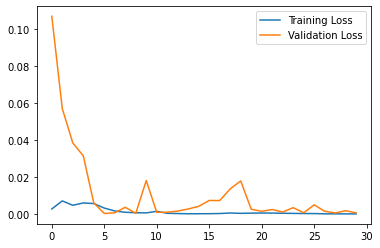

In [50]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()

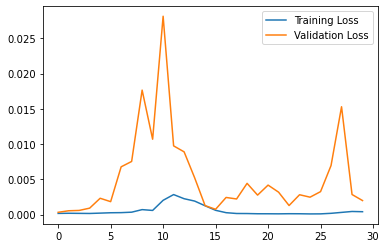

In [51]:
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.legend()

In [52]:
regressor = load_model("regressor.hdf5")
regressor.evaluate(X_test, y_test)

174/174 [==============================] - 1s 7ms/step - loss: 3.8634e-04


0.0003863429883494973

In [53]:
regressor2 = load_model("regressor2.hdf5")
regressor2.evaluate(X_test, y_test)

174/174 [==============================] - 1s 7ms/step - loss: 3.2242e-04


0.0003224165120627731

In [54]:
test = regressor.predict(X_test[0].reshape(1,24,1))

As you could see above, the LSTM model delivers better results. Let's keep that. Let's inspect now if the output has the shape that we were expecting. The model must return a single scalar by each sequence of 24 floating numbers:

In [55]:
test.shape

(1, 1)

In [56]:
scaler.inverse_transform(test)

array([[7040.252]], dtype=float32)

Great! Let's move on.

# Gathering crypto data from the API

## Getting current date and time

In [57]:
past = datetime.now(tz=timezone.utc) - timedelta(days=1) #yesterday's date
past = datetime.strftime(past, '%s') #reshaping to unix format
current = datetime.now(tz=timezone.utc).strftime('%s') #today's date

print(past)
print(current)

1610487954
1610574354


## Connecting to Poloniex public API

In [58]:
# connect to poloniex's API
url = 'https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start='+str(past)+'&end='+str(current)+'&period=300'
result = requests.get(url)
result = result.json()
print(result)

[{'date': 1610487954, 'high': 34564.73732722, 'low': 34564.73732722, 'open': 34564.73732722, 'close': 34564.73732722, 'volume': 0, 'quoteVolume': 0, 'weightedAverage': 34564.73732722}, {'date': 1610488200, 'high': 34840.22634011, 'low': 34483.25235875, 'open': 34548.3105584, 'close': 34753.9541308, 'volume': 678113.89240416, 'quoteVolume': 19.5230056, 'weightedAverage': 34734.09301302}, {'date': 1610488500, 'high': 34839.89862382, 'low': 34687.52631819, 'open': 34755.1, 'close': 34709.10846631, 'volume': 178043.21293934, 'quoteVolume': 5.11716218, 'weightedAverage': 34793.34964899}, {'date': 1610488800, 'high': 34998.99999999, 'low': 34668.57277934, 'open': 34708.27248253, 'close': 34975.73757599, 'volume': 327108.35485382, 'quoteVolume': 9.38166231, 'weightedAverage': 34866.77989945}, {'date': 1610489100, 'high': 34974.89999999, 'low': 34778, 'open': 34957.93788232, 'close': 34888.38558028, 'volume': 161909.41711048, 'quoteVolume': 4.64388757, 'weightedAverage': 34865.05964451}, {'dat

In [59]:
last_data = pd.DataFrame(result)

In [60]:
last_data

date          high           low          open         close  \
0    1610487954  34564.737327  34564.737327  34564.737327  34564.737327   
1    1610488200  34840.226340  34483.252359  34548.310558  34753.954131   
2    1610488500  34839.898624  34687.526318  34755.100000  34709.108466   
3    1610488800  34999.000000  34668.572779  34708.272483  34975.737576   
4    1610489100  34974.900000  34778.000000  34957.937882  34888.385580   
..          ...           ...           ...           ...           ...   
283  1610572800  36486.000000  36165.034288  36360.042937  36165.034288   
284  1610573100  36295.369041  36050.000000  36165.034288  36207.000000   
285  1610573400  36362.083402  36173.830227  36207.000000  36336.472049   
286  1610573700  36370.211014  36237.624718  36337.238492  36344.000000   
287  1610574000  36473.939600  36357.400335  36357.400335  36409.898966   

            volume  quoteVolume  weightedAverage  
0         0.000000     0.000000     34564.737327  
1    678113.892404    19.523006     34734.093013  
2    178043.212939     5.117162     34793.349649  
3    327108.354854     9.381662     34866.779899  
4    161909.417110     4.643888     34865.059645  
..             ...          ...              ...  
283  246248.992998     6.759819     36428.342280  
284  459154.618292    12.689537     36183.717292  
285  104700.265056     2.890021     36228.205051  
286   79766.078373     2.196883     36308.747449  
287  105739.057800     2.902303     36432.807626  

[288 rows x 8 columns]

## Preprocessing API data

In [61]:
last_data['date'] = pd.to_datetime(last_data.date, unit='s') #To get date in readable format
last_data.head()

date          high           low          open         close  \
0 2021-01-12 21:45:54  34564.737327  34564.737327  34564.737327  34564.737327   
1 2021-01-12 21:50:00  34840.226340  34483.252359  34548.310558  34753.954131   
2 2021-01-12 21:55:00  34839.898624  34687.526318  34755.100000  34709.108466   
3 2021-01-12 22:00:00  34999.000000  34668.572779  34708.272483  34975.737576   
4 2021-01-12 22:05:00  34974.900000  34778.000000  34957.937882  34888.385580   

          volume  quoteVolume  weightedAverage  
0       0.000000     0.000000     34564.737327  
1  678113.892404    19.523006     34734.093013  
2  178043.212939     5.117162     34793.349649  
3  327108.354854     9.381662     34866.779899  
4  161909.417110     4.643888     34865.059645

In [62]:
last_data = last_data[['date','weightedAverage']]
last_data.head()

date  weightedAverage
0 2021-01-12 21:45:54     34564.737327
1 2021-01-12 21:50:00     34734.093013
2 2021-01-12 21:55:00     34793.349649
3 2021-01-12 22:00:00     34866.779899
4 2021-01-12 22:05:00     34865.059645

In [63]:
last_data = last_data.resample('H', on='date')[['weightedAverage']].mean()

In [64]:
last_data = last_data[-24:]
unscaled = last_data.copy()
len(last_data)

24

In [65]:
last_data_scaled = scale_samples(last_data,last_data.columns[0],scaler)
last_data_scaled.head()

weightedAverage
date                                
2021-01-12 22:00:00         1.212598
2021-01-12 23:00:00         1.183282
2021-01-13 00:00:00         1.166893
2021-01-13 01:00:00         1.154221
2021-01-13 02:00:00         1.159600

# Predicting on API data

## Implementing Neural Networks approach

In [66]:
predictions = regressor.predict(last_data_scaled.values.reshape(1,24,1))
unscaled = unscaled.iloc[1:]
unscaled = unscaled.append(pd.DataFrame(scaler.inverse_transform(predictions)[0], index= [unscaled.index[len(unscaled)-1] + timedelta(hours=1)],columns =['weightedAverage']))
future_scaled = scale_samples(unscaled.copy(),unscaled.columns[0],scaler)
future_scaled_pred = detector.predict(future_scaled.values.reshape(1,24,1))
future_loss = np.mean(np.abs(future_scaled_pred - future_scaled.values.reshape(1,24,1)), axis=1)
unscaled['threshold'] = threshold 
unscaled['loss'] = future_loss[0][0]
unscaled['anomaly'] = unscaled.loss > threshold
unscaled.head()

weightedAverage  threshold      loss  anomaly
2021-01-12 23:00:00     33632.011767       0.15  0.667761     True
2021-01-13 00:00:00     33209.710836       0.15  0.667761     True
2021-01-13 01:00:00     32883.177680       0.15  0.667761     True
2021-01-13 02:00:00     33021.763096       0.15  0.667761     True
2021-01-13 03:00:00     33850.254210       0.15  0.667761     True

In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=unscaled.index, y=unscaled.weightedAverage.values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=unscaled.index, y=unscaled[unscaled['anomaly']==True]['weightedAverage'].values,mode='markers',marker_symbol='x',marker_size=10,name='Anomaly'))
fig.add_vrect(x0=unscaled.index[-2], x1=unscaled.index[-1],fillcolor="LightSalmon", opacity=1,layer="below", line_width=0)
fig.update_layout(showlegend=True,title="BTC price predictions and anomalies",xaxis_title="Time (UTC)",yaxis_title="Prices",font=dict(family="Courier New, monospace"))

fig.show()

## Detecting outliers with classic Unsupervised Learning models

### Isolation Forest

In [68]:
anomalies_24h = np.linspace(unscaled['weightedAverage'].min(), unscaled['weightedAverage'].max(), len(unscaled)).reshape(-1,1)
outlier = isolation_detector.predict(anomalies_24h)
unscaled['outlier'] = outlier
unscaled.head()

weightedAverage  threshold      loss  anomaly  outlier
2021-01-12 23:00:00     33632.011767       0.15  0.667761     True       -1
2021-01-13 00:00:00     33209.710836       0.15  0.667761     True       -1
2021-01-13 01:00:00     32883.177680       0.15  0.667761     True       -1
2021-01-13 02:00:00     33021.763096       0.15  0.667761     True       -1
2021-01-13 03:00:00     33850.254210       0.15  0.667761     True       -1

In [69]:
print('Anomalies in prediction: ',len(unscaled[unscaled['outlier'] == 1]))

Anomalies in prediction:  0


### KMeans

In [70]:
outlier_k_means = kmeans.predict(unscaled['weightedAverage'].values.reshape(-1, 1))
unscaled['outlier'] = outlier_k_means
unscaled.head()

weightedAverage  threshold      loss  anomaly  outlier
2021-01-12 23:00:00     33632.011767       0.15  0.667761     True        1
2021-01-13 00:00:00     33209.710836       0.15  0.667761     True        1
2021-01-13 01:00:00     32883.177680       0.15  0.667761     True        1
2021-01-13 02:00:00     33021.763096       0.15  0.667761     True        1
2021-01-13 03:00:00     33850.254210       0.15  0.667761     True        1

In [71]:
print('Anomalies in prediction: ',len(unscaled[unscaled['outlier'] == 1]))

Anomalies in prediction:  24


In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=unscaled.index, y=unscaled.weightedAverage.values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=unscaled.index, y=unscaled[unscaled['outlier']==True]['weightedAverage'].values,mode='markers',marker_symbol='x',marker_size=10,name='Anomaly'))
fig.add_vrect(x0=unscaled.index[-2], x1=unscaled.index[-1],fillcolor="LightSalmon", opacity=1,layer="below", line_width=0)
fig.update_layout(showlegend=True,title="BTC price predictions and anomalies",xaxis_title="Time (UTC)",yaxis_title="Prices",font=dict(family="Courier New, monospace"))

fig.show()

I hope this notebook has been useful to you! Thanks a lot.